In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:00<00:00, 173MB/s]
100% 149M/149M [00:00<00:00, 165MB/s]


In [ ]:
from genericpath import isdir
def get_class_paths(path):
  class_paths = []
  classes = []

  for label in os.listdir(path):
    label_path = os.path.join(path, label)

    if os.path.isdir(label_path):
      for image in os.listdir(label_path):
        image_path = os.path.join(label_path, image)
        class_paths.append(image_path)
        classes.append(label)

  df = pd.DataFrame({
      'Class Path': class_paths,
      'Class': classes
  })

  return df

In [ ]:
tr_df = get_class_paths('/content/Training')
tr_df

,Class Path,Class
0,/content/Training/notumor/Tr-no_0794.jpg,notumor
1,/content/Training/notumor/Tr-no_1039.jpg,notumor
2,/content/Training/notumor/Tr-no_0972.jpg,notumor
3,/content/Training/notumor/Tr-no_0559.jpg,notumor
4,/content/Training/notumor/Tr-no_1252.jpg,notumor
...,...,...
5707,/content/Training/glioma/Tr-gl_0255.jpg,glioma
5708,/content/Training/glioma/Tr-gl_0182.jpg,glioma
5709,/content/Training/glioma/Tr-gl_0553.jpg,glioma
5710,/content/Training/glioma/Tr-gl_0380.jpg,glioma


In [ ]:
ts_df = get_class_paths('/content/Testing')
ts_df

,Class Path,Class
0,/content/Testing/notumor/Te-no_0097.jpg,notumor
1,/content/Testing/notumor/Te-no_0301.jpg,notumor
2,/content/Testing/notumor/Te-noTr_0000.jpg,notumor
3,/content/Testing/notumor/Te-no_0222.jpg,notumor
4,/content/Testing/notumor/Te-no_0139.jpg,notumor
...,...,...
1306,/content/Testing/glioma/Te-gl_0280.jpg,glioma
1307,/content/Testing/glioma/Te-gl_0163.jpg,glioma
1308,/content/Testing/glioma/Te-gl_0194.jpg,glioma
1309,/content/Testing/glioma/Te-gl_0146.jpg,glioma


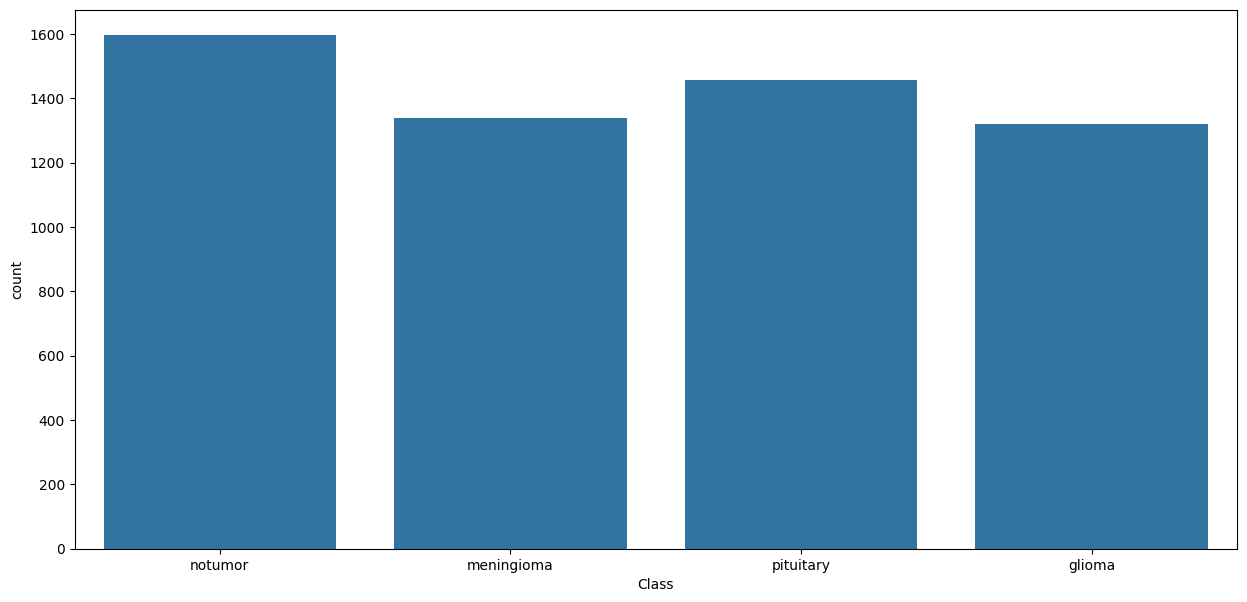

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.countplot(x='Class', data=tr_df)

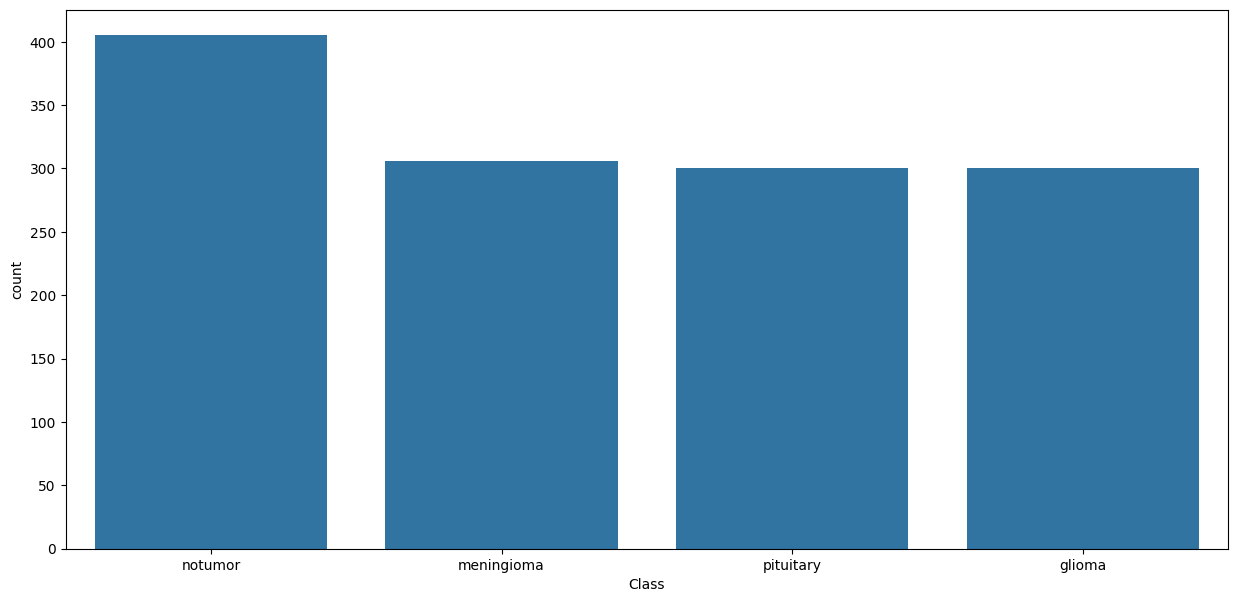

In [ ]:
plt.figure(figsize=(15,7))
ax = sns.countplot(x='Class', data=ts_df)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
valid_df, ts_df = train_test_split(ts_df, test_size=0.5, stratify=ts_df['Class'])


In [ ]:
valid_df

,Class Path,Class
772,/content/Testing/pituitary/Te-pi_0019.jpg,pituitary
537,/content/Testing/meningioma/Te-me_0202.jpg,meningioma
656,/content/Testing/meningioma/Te-me_0083.jpg,meningioma
1215,/content/Testing/glioma/Te-gl_0183.jpg,glioma
1096,/content/Testing/glioma/Te-gl_0158.jpg,glioma
...,...,...
1196,/content/Testing/glioma/Te-gl_0053.jpg,glioma
501,/content/Testing/meningioma/Te-me_0103.jpg,meningioma
693,/content/Testing/meningioma/Te-me_0167.jpg,meningioma
1064,/content/Testing/glioma/Te-gl_0223.jpg,glioma


In [ ]:
batch_size = 32
image_size = (299, 299)
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
tr_gen = image_generator.flow_from_dataframe(
    dataframe=tr_df,
    x_col='Class Path',
    y_col='Class',
    target_size=image_size,
    batch_size=batch_size
)
valid_gen = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Class Path',
    y_col='Class',
    target_size=image_size,
    batch_size=batch_size
)

ts_gen = ts_gen.flow_from_dataframe(
    dataframe=ts_df,
    x_col='Class Path',
    y_col='Class',
    target_size=image_size,
    batch_size=16,
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


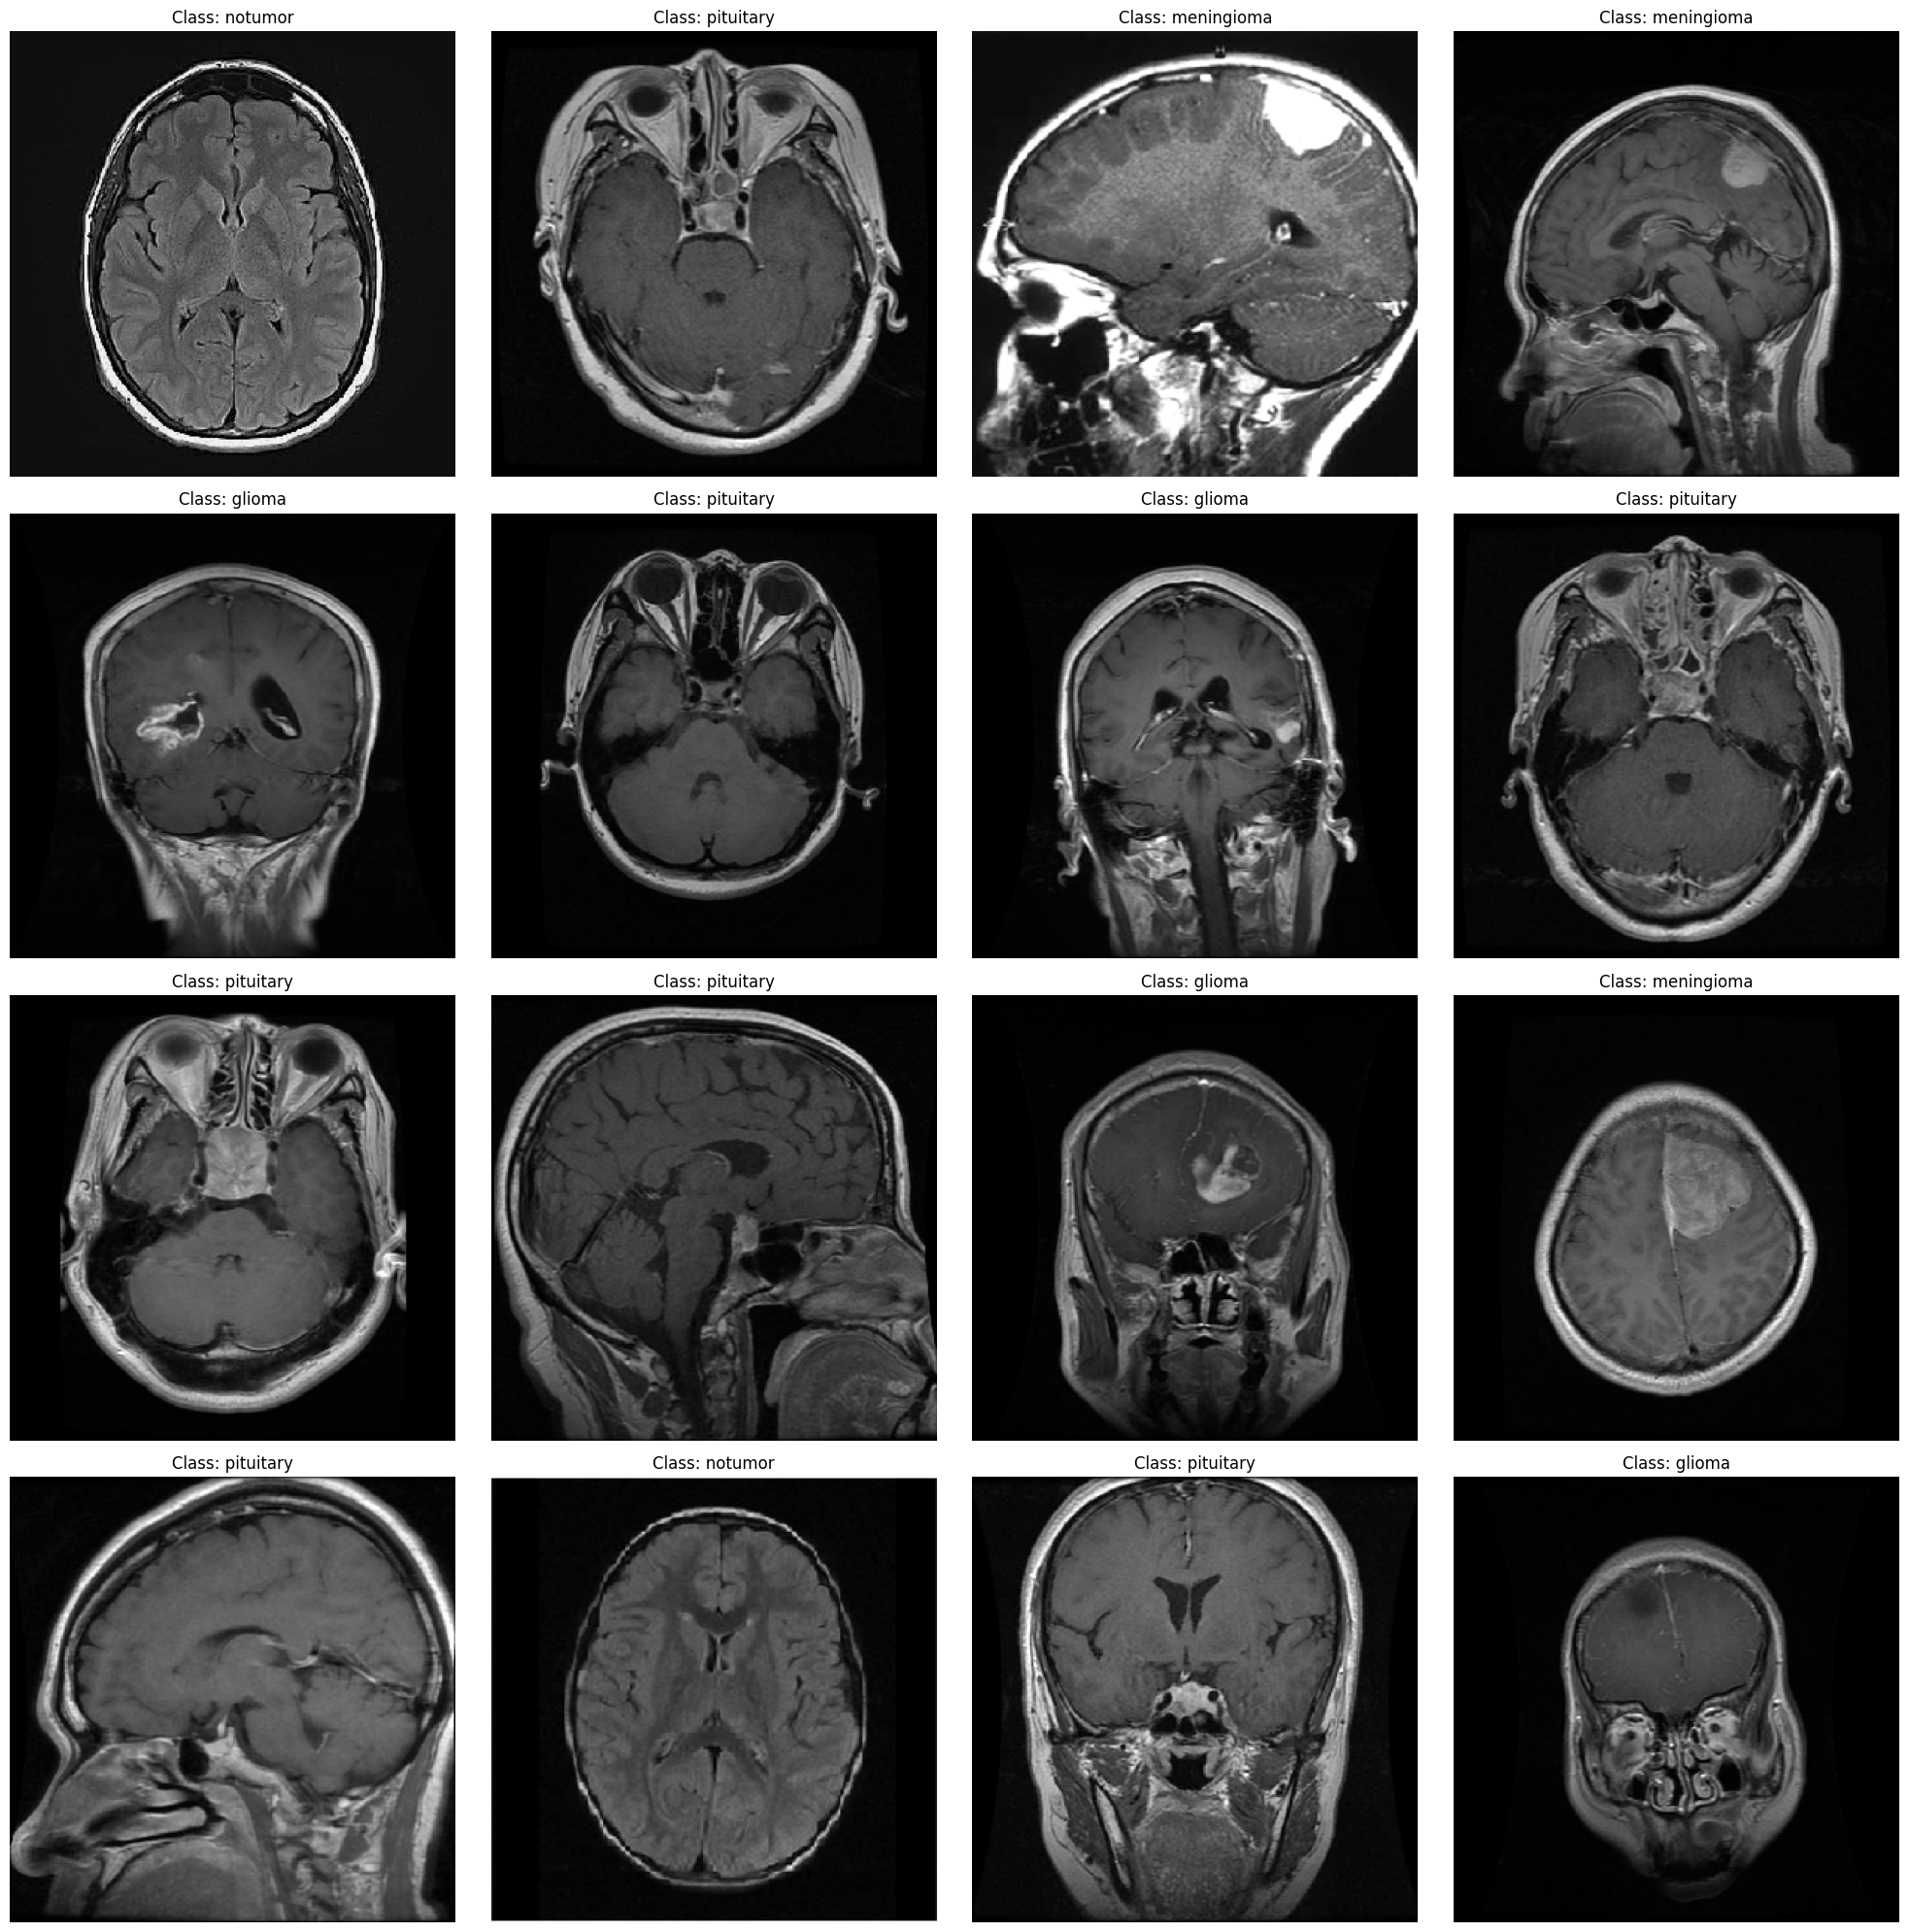

In [ ]:
plt.figure(figsize=(20,20))
for i in range(16):
  plt.subplot(4, 4, i+1)
  batch = next(tr_gen)
  image = batch[0][0]
  label = batch[1][0]

  # Get the class index
  class_index = np.argmax(label)

  # Get the list of class names and class indices
  class_names = list(tr_gen.class_indices.keys())
  class_indices = list(tr_gen.class_indices.values())

  index_position = class_indices.index(class_index)

  # Get the class name corresponding to the class index
  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.imshow(image)
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
img_shape = (299, 299, 3)

base_model = tf.keras.applications.Xception(
    input_shape=img_shape,
    include_top=False,
    weights='imagenet',
    pooling='max'
)

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate= 0.25),
    Dense(4, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [ ]:
hist = model.fit(tr_gen, epochs=5, validation_data=valid_gen)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.5148 - loss: 1.1218 - precision: 0.7250 - recall: 0.3259 - val_accuracy: 0.8733 - val_loss: 0.3578 - val_precision: 0.8961 - val_recall: 0.8427
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 789ms/step - accuracy: 0.9462 - loss: 0.1544 - precision: 0.9512 - recall: 0.9428 - val_accuracy: 0.9557 - val_loss: 0.1410 - val_precision: 0.9569 - val_recall: 0.9481
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 152s 841ms/step - accuracy: 0.9863 - loss: 0.0483 - precision: 0.9866 - recall: 0.9853 - val_accuracy: 0.9756 - val_loss: 0.0858 - val_precision: 0.9755 - val_recall: 0.9740
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 196s 807ms/step - accuracy: 0.9956 - loss: 0.0210 - precision: 0.9956 - recall: 0.9942 - val_accuracy: 0.9679 - val_loss: 0.1389 - val_precision: 0.9679 - val_recall: 0.9664
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 808ms/step - accuracy: 0.9931 - loss: 0.0178 - precision: 0.9932 - recall: 0.9931 - val_accuracy: 0.9832 - val_loss: 

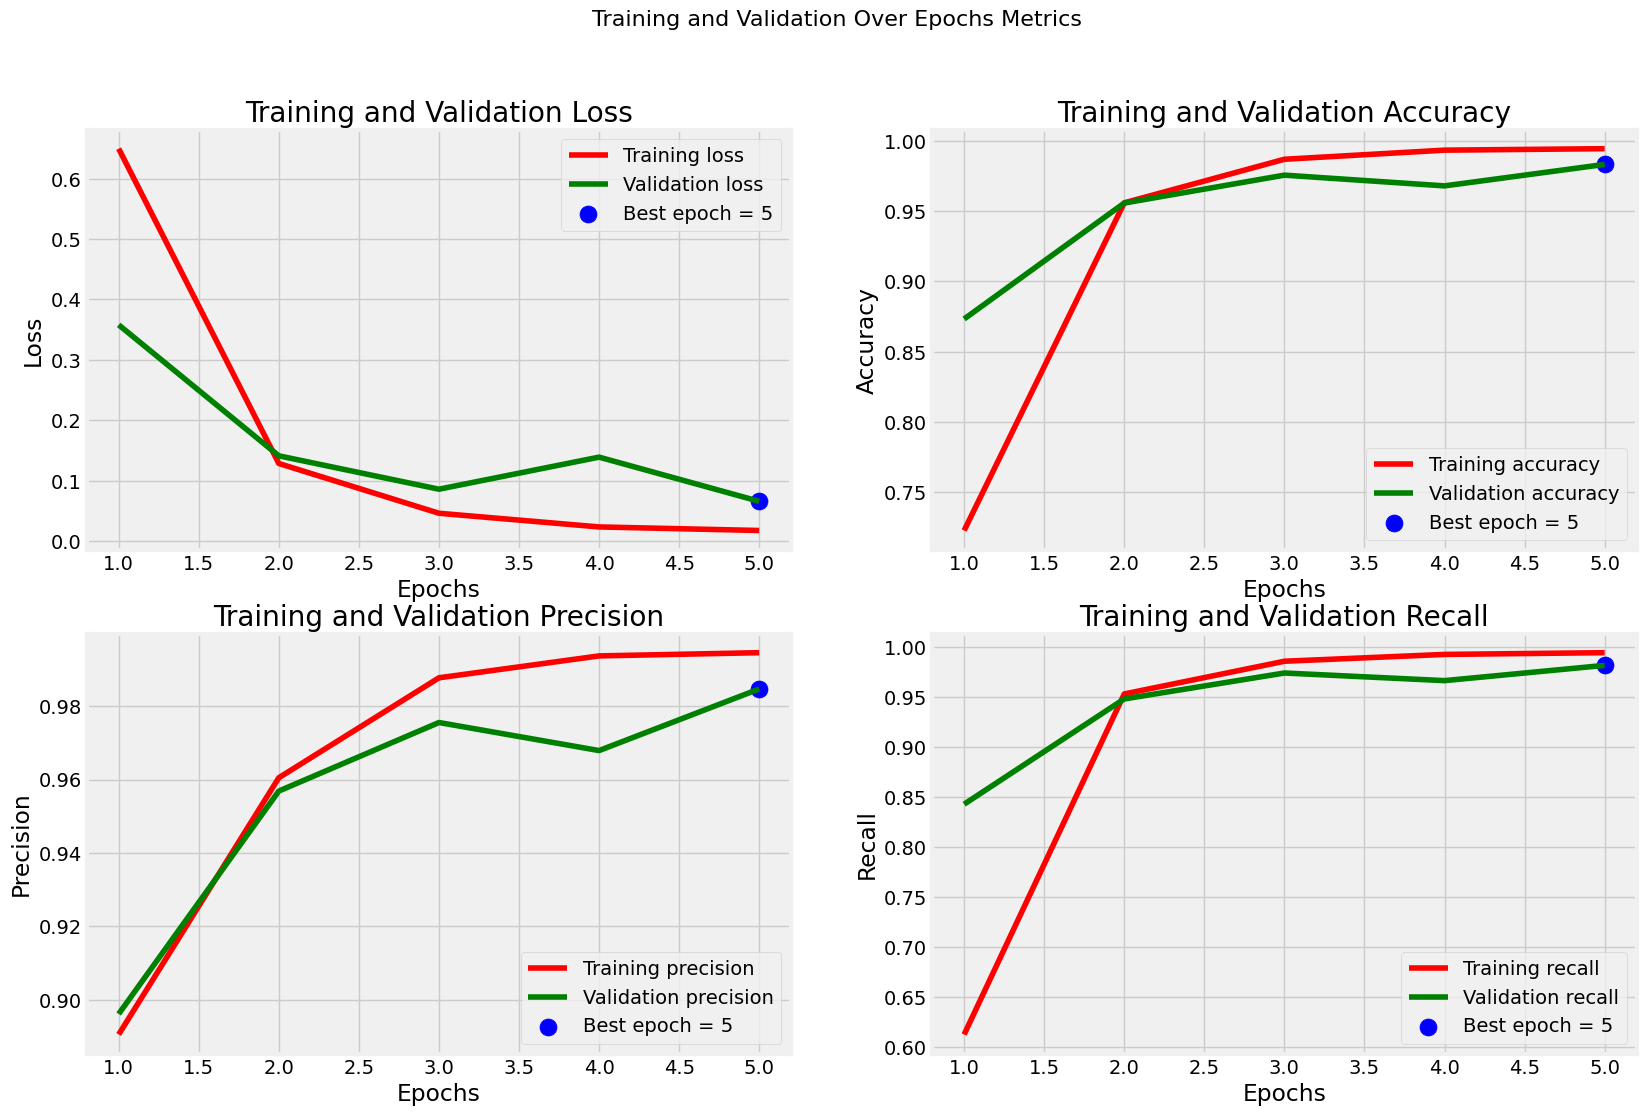

In [ ]:
# Get training and validation metrics from history
metrics = ['loss', 'accuracy', 'precision', 'recall']
tr_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])
    else:
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)

    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Training and Validation Over Epochs Metrics', fontsize=16)
plt.show()

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 44s 245ms/step - accuracy: 0.9963 - loss: 0.0091 - precision: 0.9963 - recall: 0.9963
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.9892 - loss: 0.0579 - precision: 0.9900 - recall: 0.9892
 1/41 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 1.0000 - loss: 2.5765e-04 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9881 - loss: 0.0355 - precision: 0.9881 - recall: 0.9876
Train Accuracy: 99.60%
Train Loss: 0.0104


Validation Accuracy: 98.47%
Validation Loss: 0.0607


Test Accuracy: 98.93%
Test Loss: 0.0339


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step
['glioma', 'meningioma', 'notumor', 'pituitary']


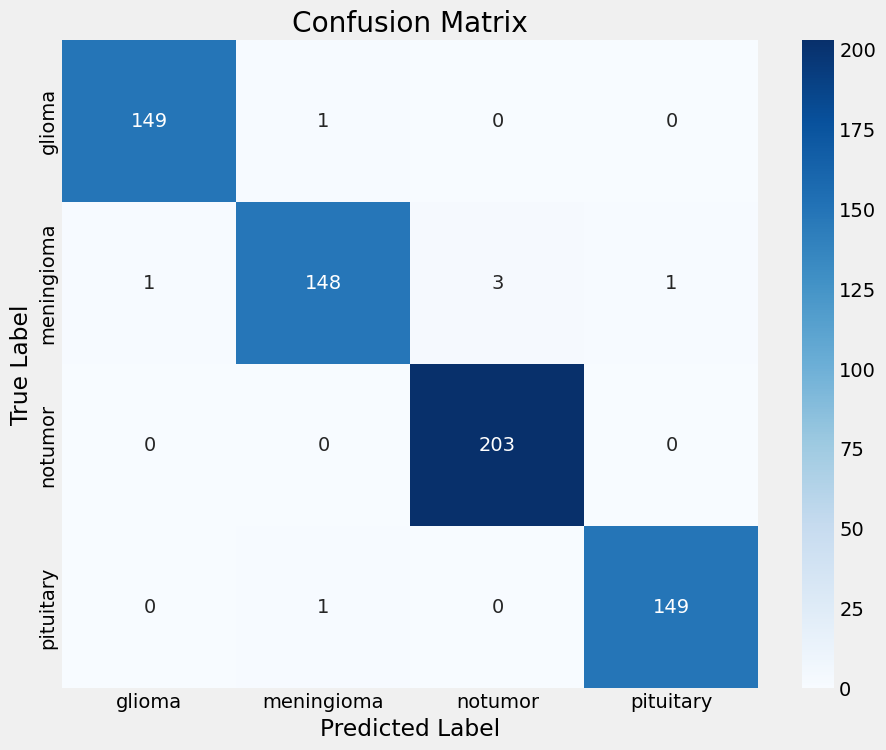

In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.values())
print(labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from PIL import  Image

def predict(img_path: str) -> None:
    # Get class labels
    labels = list(class_dict.values())

    # Create figure
    plt.figure(figsize=(6,8))

    # Load and preprocess image
    img = Image.open(img_path)
    img = img.resize((299, 299))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Get model predictions
    preditions = model.predict(img_array)
    probabilities = list(preditions[0])

    # Get predicted class
    predicted_class_idx = np.argmax(probabilities)
    predicted_class = labels[predicted_class_idx]

    # Plot original image
    plt.subplot(2, 1, 1)
    plt.imshow(img)
    plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

    # Plot prediction probabilites
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probabilities)
    plt.xlabel('Probability')
    plt.title('Prediction Probabilities')

    # Add probability labels to bars
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')

    plt.tight_layout()
    plt.show()

    print(f"\nPredicted tumor type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


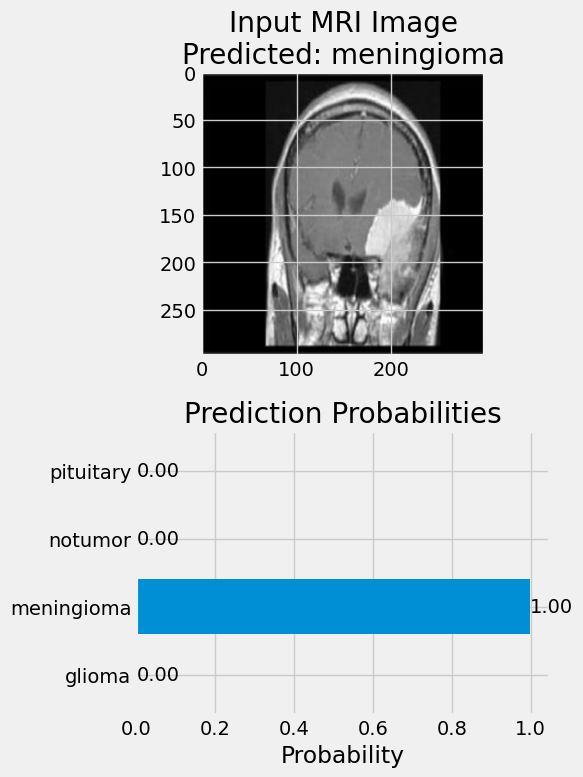


Predicted tumor type: meningioma


In [ ]:
predict("/content/Testing/meningioma/Te-meTr_0000.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


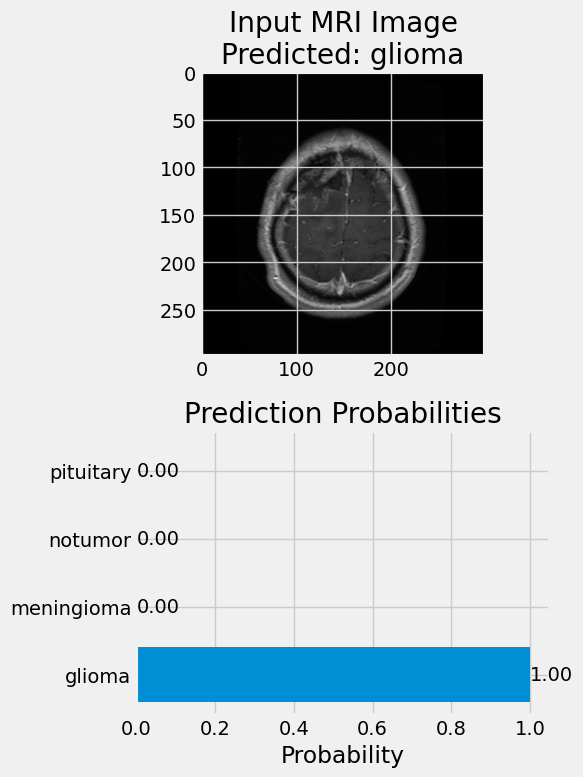


Predicted tumor type: glioma


In [ ]:
predict("/content/Testing/glioma/Te-gl_0017.jpg")

In [ ]:
model.save_weights("xception_model.weights.h5")

In [ ]:
# Custom CNN
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [ ]:
batch_size = 16
image_size = (224, 224)
image_generator = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = image_generator.flow_from_dataframe(
    dataframe=tr_df,
    x_col='Class Path',
    y_col='Class',
    target_size=image_size,
    batch_size=batch_size
)
valid_gen = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Class Path',
    y_col='Class',
    target_size=image_size,
    batch_size=batch_size
)

ts_gen = ts_gen.flow_from_dataframe(
    dataframe=ts_df,
    x_col='Class Path',
    y_col='Class',
    target_size=image_size,
    batch_size=16,
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
 # Create a Sequential model
cnn_model = Sequential()

# Convolutional layers
cnn_model.add(Conv2D(512, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output for fully connected layers
cnn_model.add(Flatten())

# Fully connected layers
cnn_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn_model.add(Dropout(0.35))

cnn_model.add(Dense(4, activation='softmax')) # Output layer with 4 neurons for the 4 classes

# Compile the model
cnn_model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Display the model summary
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 512)       │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 512)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 256)       │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,775,620 (18.22 MB)

 Trainable params: 4,775,620 (18.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(tr_gen, epochs=10, validation_data=valid_gen)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 296ms/step - accuracy: 0.9158 - loss: 0.3396 - precision_1: 0.9196 - recall_1: 0.9101 - val_accuracy: 0.9115 - val_loss: 0.3613 - val_precision_1: 0.9126 - val_recall_1: 0.9084
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 146s 309ms/step - accuracy: 0.9394 - loss: 0.2795 - precision_1: 0.9414 - recall_1: 0.9344 - val_accuracy: 0.9221 - val_loss: 0.3483 - val_precision_1: 0.9319 - val_recall_1: 0.9191
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 143s 309ms/step - accuracy: 0.9584 - loss: 0.2465 - precision_1: 0.9600 - recall_1: 0.9568 - val_accuracy: 0.9481 - val_loss: 0.2815 - val_precision_1: 0.9479 - val_recall_1: 0.9435
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 140s 306ms/step - accuracy: 0.9647 - loss: 0.2127 - precision_1: 0.9662 - recall_1: 0.9630 - val_accuracy: 0.9573 - val_loss: 0.2446 - val_precision_1: 0.9572 - val_recall_1: 0.9557
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 112s 309ms/step - accuracy: 0.9688 - loss: 0.1966 - precision_1: 0.9701 

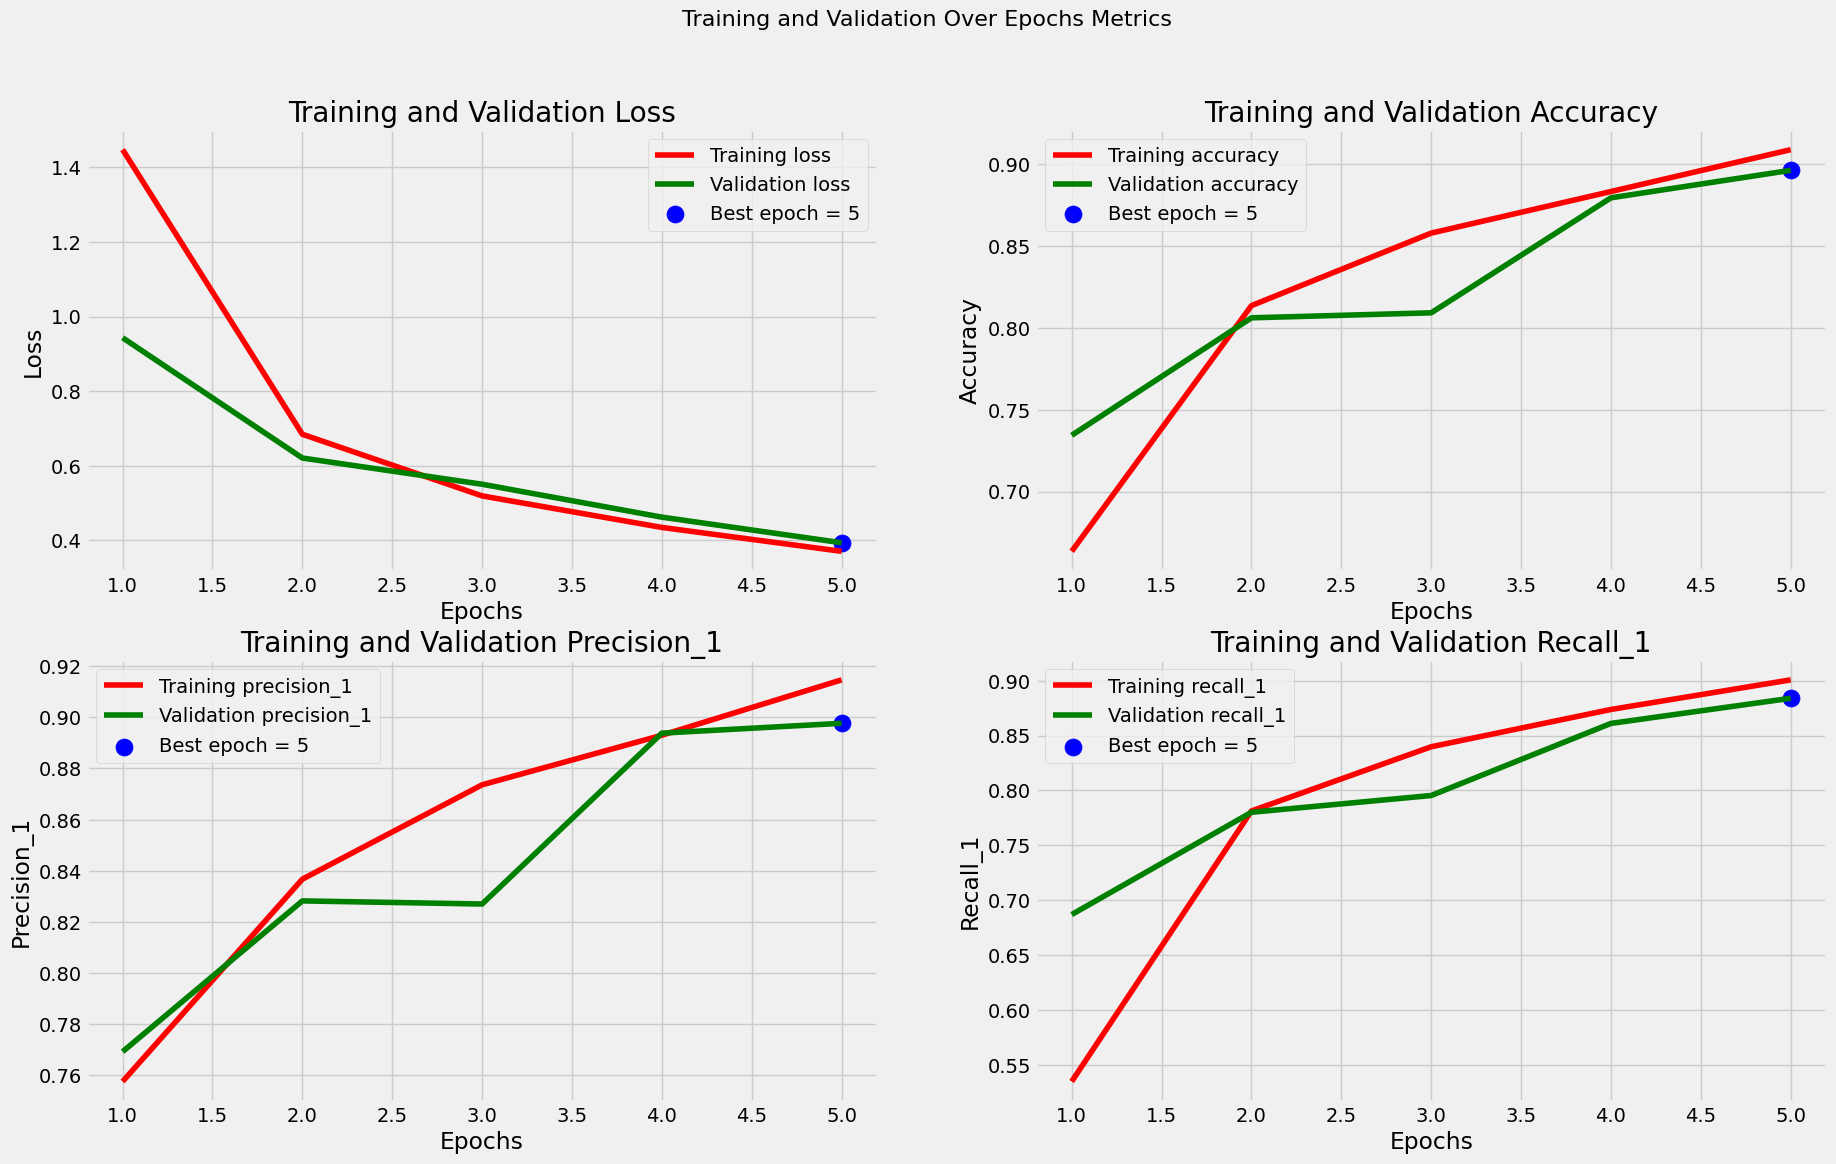

In [ ]:
# Get training and validation metrics from history
metrics = ['loss', 'accuracy', 'precision_1', 'recall_1']
tr_metrics = {m: history.history[m] for m in metrics}
val_metrics = {m: history.history[f'val_{m}'] for m in metrics}

# Find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
    if m == 'loss':
        idx = np.argmin(val_metrics[m])
    else:
        idx = np.argmax(val_metrics[m])
    best_epochs[m] = idx + 1
    best_values[m] = val_metrics[m][idx]

# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    epochs = range(1, len(tr_metrics[metric]) + 1)

    plt.plot(epochs, tr_metrics[metric], 'r', label=f'Training {metric}')
    plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
    plt.scatter(best_epochs[metric], best_values[metric], s=150, c='blue', label=f'Best epoch = {best_epochs[metric]}')

    plt.title(f'Training and Validation {metric.title()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)

plt.suptitle('Training and Validation Over Epochs Metrics', fontsize=16)
plt.show()

In [ ]:
train_score = cnn_model.evaluate(tr_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(ts_gen, verbose=1)

print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"\n\nValidation Accuracy: {valid_score[1]*100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"\n\nTest Accuracy: {test_score[1]*100:.2f}%")
print(f"Test Loss: {test_score[0]:.4f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - accuracy: 0.9991 - loss: 0.0958 - precision_1: 0.9991 - recall_1: 0.9991
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9883 - loss: 0.2134 - precision_1: 0.9883 - recall_1: 0.9883
 2/41 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9531 - loss: 0.1450 - precision_1: 0.9531 - recall_1: 0.9531 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9684 - loss: 0.1686 - precision_1: 0.9684 - recall_1: 0.9684
Train Accuracy: 99.82%
Train Loss: 0.0966


Validation Accuracy: 98.32%
Validation Loss: 0.2035


Test Accuracy: 96.49%
Test Loss: 0.1930


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step
['glioma', 'meningioma', 'notumor', 'pituitary']


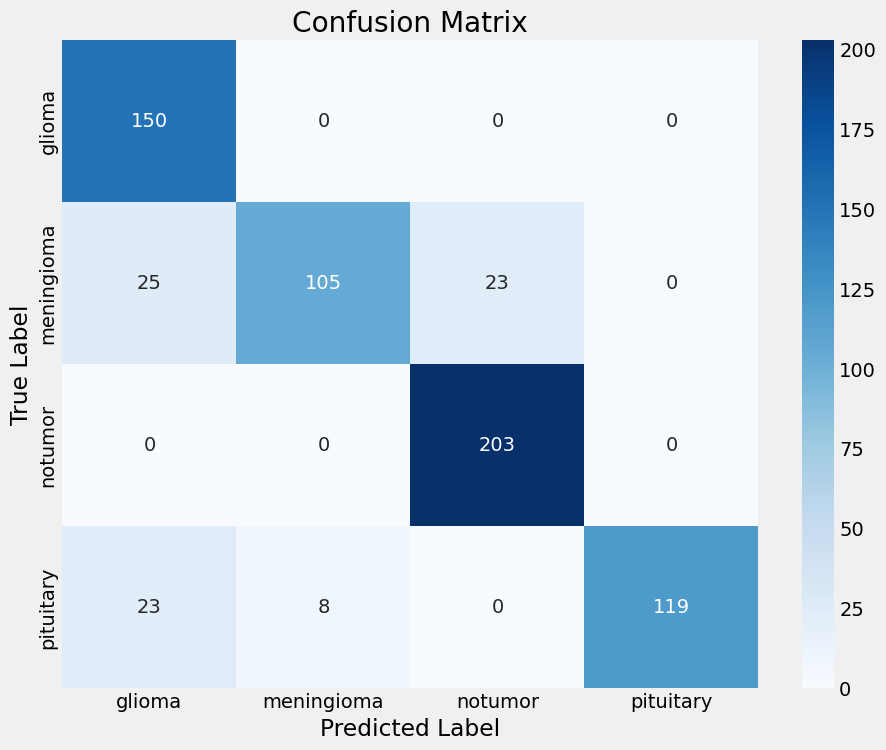

In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'glioma',
    1: 'meningioma',
    2: 'notumor',
    3: 'pituitary'
}

# Then create and display the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.values())
print(labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       150
           1       0.93      0.69      0.79       153
           2       0.90      1.00      0.95       203
           3       1.00      0.79      0.88       150

    accuracy                           0.88       656
   macro avg       0.90      0.87      0.87       656
weighted avg       0.90      0.88      0.88       656



In [ ]:
cnn_model.save("cnn_model.h5")

# Part 2: Streamlit Web App

In [ ]:
! pip install streamlit pyngrok python-dotenv
! pip install tensorflow --upgrade

In [ ]:
from threading import Thread
from pyngrok import ngrok
from google.colab import userdata

In [ ]:
ngrok_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_token)

In [ ]:
def run_streamlit():
    os.system("streamlit run /content/app.py --server.port 8501")

In [ ]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import plotly.graph_objects as go
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import google.generativeai as genai
from google.colab import userdata
import PIL.Image
import os
from google.colab import userdata
from dotenv import load_dotenv
load_dotenv()

output_dir = 'saliency_maps'
os.makedirs(output_dir, exist_ok=True)

def load_xception_model(model_path):
    img_shape=(299,299,3)
    base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet",
                                               input_shape=img_shape, pooling='max')
    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate=0.3),
        Dense(128, activation='relu'),
        Dropout(rate=0.25),
        Dense(4, activation='softmax')
    ])

    model.build((None,) + img_shape)

    # Compile the model
    model.compile(Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           Precision(),
                           Recall()])
    model.load_weights(model_path)
    return model


def generate_saliency_map(model, img_array, class_index, img_size):
    with tf.GradientTape() as tape:
        img_tensor = tf.convert_to_tensor(img_array)
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        target_class = predictions[:, class_index]

    gradients = tape.gradient(target_class, img_tensor)
    gradients = tf.math.abs(gradients)
    gradients = tf.reduce_max(gradients, axis=-1)
    gradients = gradients.numpy().squeeze()

    # Resize gradients to match original image size
    gradients = cv2.resize(gradients, img_size)

    # Create a circular mask for the brain area
    center = (gradients.shape[0] // 2, gradients.shape[1] // 2)
    radius = min(center[0], center[1]) - 10
    y, x = np.ogrid[:gradients.shape[0], :gradients.shape[1]]
    mask = (x - center[0]**2 + (y - center[1]))**2 <= radius**2

    # Apply mask to gradients
    gradients = gradients * mask

    # Normalize only the brain area
    brain_gradients = gradients[mask]
    if brain_gradients.max() > brain_gradients.min():
        brain_gradients = (brain_gradients - brain_gradients.min()) / (brain_gradients.max() - brain_gradients.min())
    gradients[mask] = brain_gradients

    # Apply a higher threshold
    threshold = np.percentile(gradients[mask], 80)
    gradients[gradients < threshold] = 0

    # Apply more aggressive smoothing
    gradients = cv2.GaussianBlur(gradients, (11, 11), 0)

    # Create a heatmap overlay with enhanced contrast
    heatmap = cv2.applyColorMap(np.unit8(255 * gradients), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match orginal image size
    heatmap = cv2.resize(heatmap, img_size)

    # Superimpose the heatmap on original image with increased opacity
    original_img = image.img_to_array(img)
    superimposed_img = heatmap * 0.7 + original_img * 0.3
    superimposed_img = superimposed_img.astype(np.unit8)

    img_path = os.path.join(output_dir, upload_file.name)
    with open(img_path, "wb") as f:
        f.write(uploaded_file.getbuffer())

    saliency_map_path = f'saliency_maps/{uploaded_file.name}'

    # Save the saliency map
    cv2.imwrite(saliency_map_path, cv2.cvtColor(superimposed_img, cv2.COLOR_RGB2BGR))

    return superimposed_img

st.title("Brain Tumor Classification")
st.write("Upload an image of a brain MRI scan to classify the tumor type.")
uploaded_file = st.file_uploader("Choose an image...", type=['jpg', 'jpeg', 'png'])

if uploaded_file is not None:

    selected_model = st.radio(
        "Select Model",
        ("Transfer Learning - Xception", "Custom CNN")
    )

    if selected_model == "Transfer Learning - Xception":
        model = load_xception_model("/content/xception_model.weights.h5")
        img_size = (299, 299)
    else:
        model = load_model("/content/cnn_model.h5")
        img_size = (224, 224)

    labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    img = image.load_img(uploader_file, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)

    # Get the class with the highest probability
    class_index = np.argmax(prediction[0])
    result = labels[class_index]

    st.write(f"Prediction Class: {result}")
    st.write("Prediction:")
    for label, prob in zip(labels, prediction[0]):
        st.write(f"{label}: {prob * 100:.2f}%")

    saliency_map = generate_saliency_map(model, img_array, class_index, img_size)

    col1, col2 = st.columns(2)
    with col1:
        st.image(uploaded_file, caption='Uploaded Image', use_column_width=True)
    with col2:
        st.image(saliency_map, caption='Saliency Map', use_column_width=True)



Overwriting app.py


In [ ]:
thread = Thread(target=run_streamlit)
thread.start()

In [ ]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print("Public URL:", public_url)

Public URL: NgrokTunnel: "https://36b7-35-199-151-117.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
    print(f"Stopping tunnel: {tunnel.public_url} -> {tunnel.config['addr']}")
    ngrok.disconnect(tunnel.public_url)

Stopping tunnel: https://d14f-35-199-151-117.ngrok-free.app -> http://localhost:8501
Stopping tunnel: https://d29f-35-199-151-117.ngrok-free.app -> http://localhost:8501
Stopping tunnel: https://7ccb-35-199-151-117.ngrok-free.app -> http://localhost:8501
